# Overview

This week we'll talk about advanced network measures (beyond the degree distribution). We will use these tools to make sense of the network of the Rock Musicians on Wikipedia. 
This is the outline for today:

* Visualization and qualitative analysis of the Rock Music Artists Network
* Properties of the network structure
* Finally some more visualizations

> _Reading_: This week, the reading is mostly for reference. It's for you to have a place to go, if you want more detailed information about the topics that I cover in the video lectures. Thus, I recommend you check out **Chapter 9** of the network science book. In particular, we'll delve into Section 9.4 in the exercises below. We will also talk a little bit about degree correlations - you can read about those in **Chapter 7**.

# Part A: Let's  visualise some more!

For the rest of the course, we will primarily use[`ForceAtlas2`](https://journals.plos.org/plosone/article%3Fid=10.1371/journal.pone.0098679), a layout algorithm which was developed by the creators of the [Gephy graph analysis software](https://gephi.org). IMHO it's the prettiest network layout algorithm & since last year it's been implemented in NetworkX, so it should be easy to use.

*Exercise 1:* Plot the Network using ForceAtlas2. For visualization, you should work with the network from last time, the Giant Connected Component ... and the undirected version.

> * Visualize the network using NetworkX
>   * Node color should depend on the `length_of_content` attribute (see notes from last week).
>   * Node size should depend on the node *degree*
> * Play with the force atlas algorithm parameters to obtain a visualization you like. 

<div class="alert alert-block alert-info">
It's OK to use your LLM as much as needed for this exercise. The only goal is to create a nice visualization.
</div>

## ForceAtlas2 plot on the undirected GCC

**Visualize the undirected version of last week’s network (use the Giant Connected Component). Color nodes by the length of content attribute and size nodes by degree. Use a ForceAtlas2 layout and tune its parameters.**

In [4]:
import os, pickle, math
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

np.random.seed(42)                 # for reproducibility where random init is used
plt.rcParams["figure.dpi"] = 140   # nicer figures

graph_path = "rock_performers_LWCC.gpickle"
assert os.path.exists(graph_path), f"Missing {graph_path}. Re-open Week 4 and run the 'Save for Week 5' cell."

with open(graph_path, "rb") as f:
    H = pickle.load(f)

print(f"Loaded H (Week 4): {H.number_of_nodes()} nodes, {H.number_of_edges()} edges, directed={H.is_directed()}")

# Make undirected and extract Giant Connected Component
G_und = H.to_undirected()
gcc = max(nx.connected_components(G_und), key=len)
G = G_und.subgraph(gcc).copy()
print(f"Undirected GCC: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges")

# Attribute naming: last week likely used 'content_length'. The exercise says 'length_of_content'.
# Create an alias so both names work.
for n, data in G.nodes(data=True):
    if "length_of_content" not in data:
        data["length_of_content"] = data.get("content_length", 0)


# Base layout parameters (tweak in the sandbox cell below)
pos = nx.forceatlas2_layout(
    G,
    max_iter=800,
    dissuade_hubs=True,   # like Gephi's "Dissuade hubs"
    scaling_ratio=2.5,
    gravity=1.0,
    seed=42
)



Loaded H (Week 4): 483 nodes, 7587 edges, directed=True
Undirected GCC: 483 nodes, 6299 edges


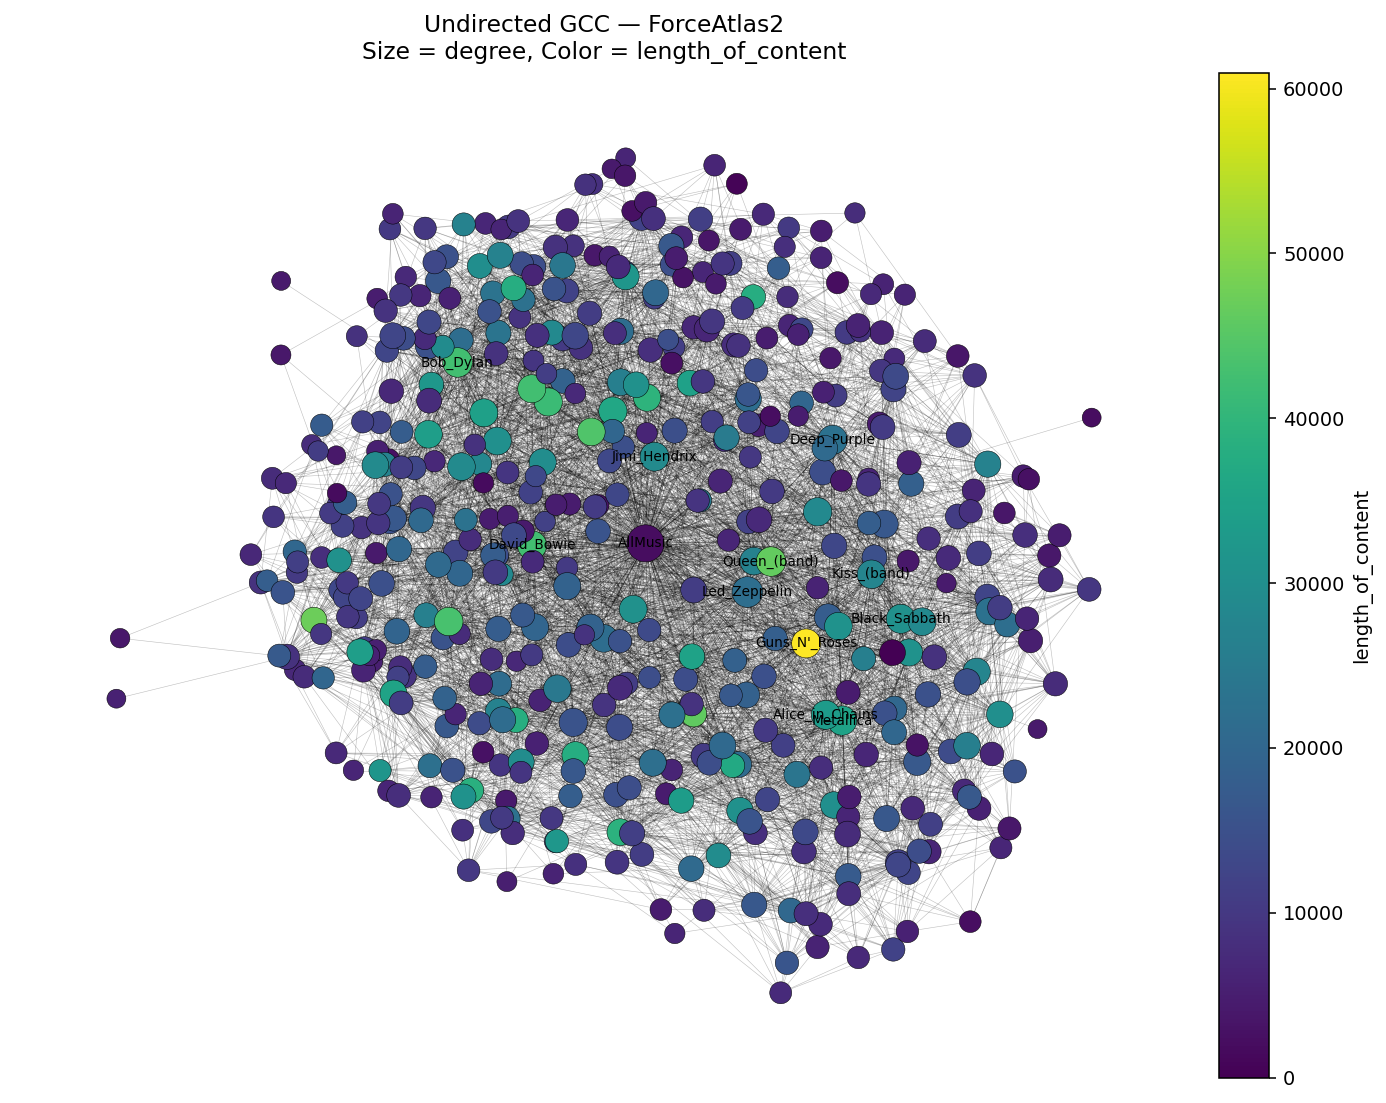

In [5]:
# Node size by (undirected) degree — use sqrt to compress heavy tails
deg = dict(G.degree())
sizes = np.array([80 + 15*math.sqrt(deg[v]) for v in G.nodes()])

# Node color by length_of_content
content = np.array([G.nodes[v].get("length_of_content", 0) for v in G.nodes()])
norm = Normalize(vmin=float(content.min()), vmax=float(content.max()))
cmap = plt.cm.viridis
node_colors = cmap(norm(content))

# ---- Draw ----
fig, ax = plt.subplots(figsize=(10, 8))
nx.draw_networkx_edges(G, pos, ax=ax, width=0.3, alpha=0.25)
nx.draw_networkx_nodes(
    G, pos, ax=ax,
    node_size=sizes,
    node_color=node_colors,
    linewidths=0.25,
    edgecolors="black"
)

# Label a few top-degree nodes (optional)
k = 12
label_nodes = set(sorted(deg, key=deg.get, reverse=True)[:k])
labels = {n: n for n in G if n in label_nodes}
nx.draw_networkx_labels(G, pos, labels=labels, font_size=7, ax=ax)

# Colorbar
sm = ScalarMappable(norm=norm, cmap=cmap); sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, fraction=0.04, pad=0.02)
cbar.set_label("length_of_content")

plt.title("Undirected GCC — ForceAtlas2\nSize = degree, Color = length_of_content")
plt.axis("off")
plt.tight_layout()
plt.show()


This layout positions densely connected groups closer together while hub dissuasion prevents high-degree nodes from over-attracting their neighbors. Larger nodes (high degree) are visually prominent, while color reflects the content length attribute. Clusters suggest topical or relational communities inherited from the original data. Sparse bridges appear stretched between denser regions.

In [6]:
# Try a different look by changing these and re-running this cell + the draw cell.
fa2_params = dict(
    max_iter=1000,         # more iterations -> more settled layout (longer runtime)
    dissuade_hubs=False,   # try False to let hubs pull neighbors more
    scaling_ratio=3.5,     # larger -> more spread
    gravity=2.0,           # increase to pull everything toward the center
    seed=42
)

pos = nx.forceatlas2_layout(G, **fa2_params)
print("Recomputed ForceAtlas2 with:", fa2_params)


Recomputed ForceAtlas2 with: {'max_iter': 1000, 'dissuade_hubs': False, 'scaling_ratio': 3.5, 'gravity': 2.0, 'seed': 42}


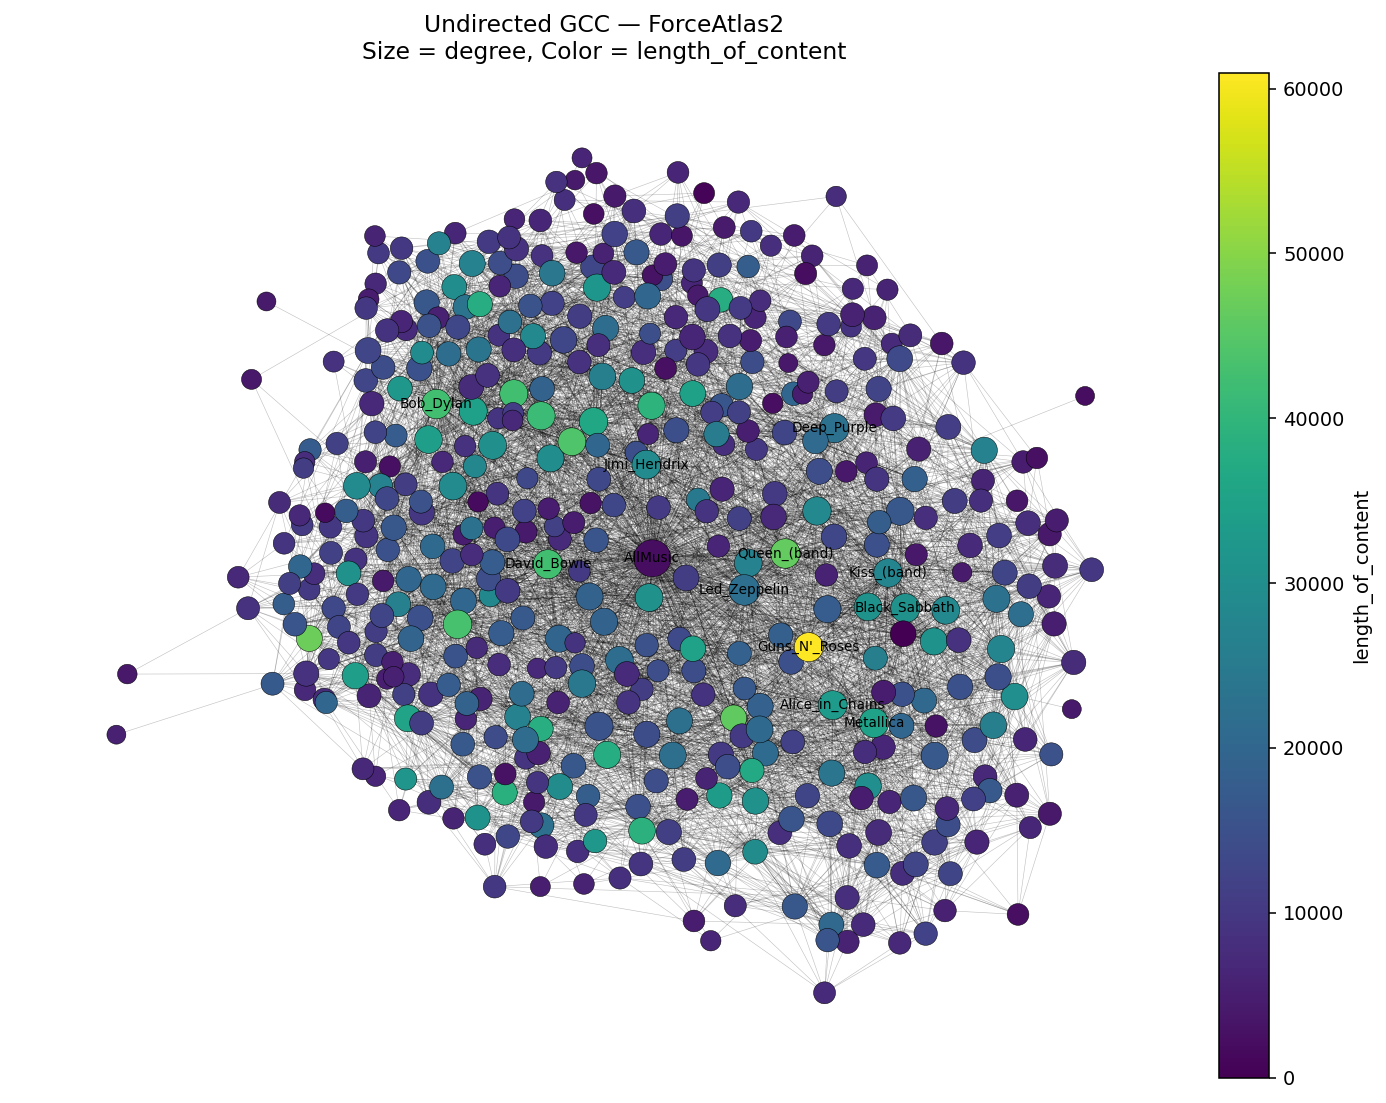

In [7]:
# Node size by (undirected) degree — use sqrt to compress heavy tails
deg = dict(G.degree())
sizes = np.array([80 + 15*math.sqrt(deg[v]) for v in G.nodes()])

# Node color by length_of_content
content = np.array([G.nodes[v].get("length_of_content", 0) for v in G.nodes()])
norm = Normalize(vmin=float(content.min()), vmax=float(content.max()))
cmap = plt.cm.viridis
node_colors = cmap(norm(content))

# ---- Draw ----
fig, ax = plt.subplots(figsize=(10, 8))
nx.draw_networkx_edges(G, pos, ax=ax, width=0.3, alpha=0.25)
nx.draw_networkx_nodes(
    G, pos, ax=ax,
    node_size=sizes,
    node_color=node_colors,
    linewidths=0.25,
    edgecolors="black"
)

# Label a few top-degree nodes (optional)
k = 12
label_nodes = set(sorted(deg, key=deg.get, reverse=True)[:k])
labels = {n: n for n in G if n in label_nodes}
nx.draw_networkx_labels(G, pos, labels=labels, font_size=7, ax=ax)

# Colorbar
sm = ScalarMappable(norm=norm, cmap=cmap); sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, fraction=0.04, pad=0.02)
cbar.set_label("length_of_content")

plt.title("Undirected GCC — ForceAtlas2\nSize = degree, Color = length_of_content")
plt.axis("off")
plt.tight_layout()
plt.show()

**Play with parameters**

*Exercise 2*: We continue with a qualitative inspection of the Wikipedia pages. Inspecting the data manually will develop intuitions that will help us to intepret our quantitative results. We investigate the reasons for links between characters to exist on Wikipedia.

> 1. Consider the nodes with highest in-degree in the network. Open the corresponding Wikipedia page.
>    * Consider the set of neighbours pointing towards the node found above. 
>    * What is the relation between the band/mucisians you identified and their network neighbours? (e.g. did they sing a song together, did one write a song for the other?, etc ...). You don't need to come up with a grand theory of Rock Music here, I just want you to think about how links arise, why the links are there.
>    * Repeat the exercise for the highest out-degree node. 
>    * Are there differences between reasons for out- and in-links? Again, there's no right answer here. I just want you to think about some of the reasons why links may occur in Wikipedia. Answer in your own words.
> 4. Create a scatter plot, where each node is a point, and the axes show in- versus out-degree. That way you can visually inspect the patterns of how in- and out-degree are connected across all the nodes in the network. Comment on what you see.
> 5. Are there any nodes with high(ish) out-degree and with few incoming connections? If yes, open WikiPages of those bands/mucisians and explain what happens?
> 6. Are there any nodes with high in-degree and few going connections? Again, open the WikiPages corresponding to those nodes and explain what happens?

### Degree stats and helpers (URLs, pretty printing)

In [8]:
def wiki_url(name: str) -> str:
    # heuristic: convert spaces to underscores; leave punctuation as-is
    # tweak here if your node names are already wiki slugs
    slug = str(name).replace(" ", "_")
    return f"https://en.wikipedia.org/wiki/{slug}"

# Compute in-/out-degree (on the directed graph)
in_deg  = dict(H.in_degree())
out_deg = dict(H.out_degree())

# Top-k convenience
def topk(d, k=10):
    return sorted(d.items(), key=lambda x: x[1], reverse=True)[:k]

print("Top 10 by in-degree:")
for n, d in topk(in_deg):
    print(f"{d:4d}  {n}  ->  {wiki_url(n)}")

print("\nTop 10 by out-degree:")
for n, d in topk(out_deg):
    print(f"{d:4d}  {n}  ->  {wiki_url(n)}")


Top 10 by in-degree:
 355  AllMusic  ->  https://en.wikipedia.org/wiki/AllMusic
 118  Led_Zeppelin  ->  https://en.wikipedia.org/wiki/Led_Zeppelin
  95  Bob_Dylan  ->  https://en.wikipedia.org/wiki/Bob_Dylan
  87  Queen_(band)  ->  https://en.wikipedia.org/wiki/Queen_(band)
  84  David_Bowie  ->  https://en.wikipedia.org/wiki/David_Bowie
  84  Metallica  ->  https://en.wikipedia.org/wiki/Metallica
  77  Jimi_Hendrix  ->  https://en.wikipedia.org/wiki/Jimi_Hendrix
  73  Black_Sabbath  ->  https://en.wikipedia.org/wiki/Black_Sabbath
  73  Nirvana_(band)  ->  https://en.wikipedia.org/wiki/Nirvana_(band)
  73  U2  ->  https://en.wikipedia.org/wiki/U2

Top 10 by out-degree:
  74  Alice_in_Chains  ->  https://en.wikipedia.org/wiki/Alice_in_Chains
  72  Deep_Purple  ->  https://en.wikipedia.org/wiki/Deep_Purple
  61  Black_Sabbath  ->  https://en.wikipedia.org/wiki/Black_Sabbath
  53  Def_Leppard  ->  https://en.wikipedia.org/wiki/Def_Leppard
  52  Guns_N'_Roses  ->  https://en.wikipedia.org/

In [9]:
# Node with highest in-degree
node_max_in, max_in = max(in_deg.items(), key=lambda x: x[1])
preds = list(H.predecessors(node_max_in))

print(f"HIGHEST IN-DEGREE: {node_max_in} (in={max_in}, out={out_deg.get(node_max_in, 0)})")
print("Wikipedia:", wiki_url(node_max_in))
print(f"\nPredecessors -> {node_max_in} (count={len(preds)}):")

# show up to N neighbors, sorted by their out-degree (handy to spot list-like pages)
N = 25
preds_sorted = sorted(preds, key=lambda v: out_deg.get(v, 0), reverse=True)
for v in preds_sorted[:N]:
    print(f"  - {v:30s}  out={out_deg.get(v,0):3d}  in={in_deg.get(v,0):3d}  {wiki_url(v)}")


HIGHEST IN-DEGREE: AllMusic (in=355, out=2)
Wikipedia: https://en.wikipedia.org/wiki/AllMusic

Predecessors -> AllMusic (count=355):
  - Alice_in_Chains                 out= 74  in= 51  https://en.wikipedia.org/wiki/Alice_in_Chains
  - Deep_Purple                     out= 72  in= 50  https://en.wikipedia.org/wiki/Deep_Purple
  - Black_Sabbath                   out= 61  in= 73  https://en.wikipedia.org/wiki/Black_Sabbath
  - Def_Leppard                     out= 53  in= 39  https://en.wikipedia.org/wiki/Def_Leppard
  - Guns_N'_Roses                   out= 52  in= 62  https://en.wikipedia.org/wiki/Guns_N'_Roses
  - Rush_(band)                     out= 48  in= 36  https://en.wikipedia.org/wiki/Rush_(band)
  - Metallica                       out= 48  in= 84  https://en.wikipedia.org/wiki/Metallica
  - Queen_(band)                    out= 46  in= 87  https://en.wikipedia.org/wiki/Queen_(band)
  - The_Smashing_Pumpkins           out= 45  in= 17  https://en.wikipedia.org/wiki/The_Smashing_Pump

In [10]:
node_max_out, max_out = max(out_deg.items(), key=lambda x: x[1])
succs = list(H.successors(node_max_out))

print(f"HIGHEST OUT-DEGREE: {node_max_out} (out={max_out}, in={in_deg.get(node_max_out, 0)})")
print("Wikipedia:", wiki_url(node_max_out))
print(f"\nSuccessors from {node_max_out} (count={len(succs)}):")

# show up to N neighbors, sorted by their in-degree (spot who receives attention)
N = 25
succs_sorted = sorted(succs, key=lambda v: in_deg.get(v, 0), reverse=True)
for v in succs_sorted[:N]:
    print(f"  - {v:30s}  in={in_deg.get(v,0):3d}  out={out_deg.get(v,0):3d}  {wiki_url(v)}")


HIGHEST OUT-DEGREE: Alice_in_Chains (out=74, in=51)
Wikipedia: https://en.wikipedia.org/wiki/Alice_in_Chains

Successors from Alice_in_Chains (count=74):
  - AllMusic                        in=355  out=  2  https://en.wikipedia.org/wiki/AllMusic
  - Led_Zeppelin                    in=118  out= 30  https://en.wikipedia.org/wiki/Led_Zeppelin
  - Queen_(band)                    in= 87  out= 46  https://en.wikipedia.org/wiki/Queen_(band)
  - David_Bowie                     in= 84  out= 21  https://en.wikipedia.org/wiki/David_Bowie
  - Metallica                       in= 84  out= 48  https://en.wikipedia.org/wiki/Metallica
  - Jimi_Hendrix                    in= 77  out= 32  https://en.wikipedia.org/wiki/Jimi_Hendrix
  - Nirvana_(band)                  in= 73  out= 17  https://en.wikipedia.org/wiki/Nirvana_(band)
  - Black_Sabbath                   in= 73  out= 61  https://en.wikipedia.org/wiki/Black_Sabbath
  - U2                              in= 73  out= 15  https://en.wikipedia.org/wiki/

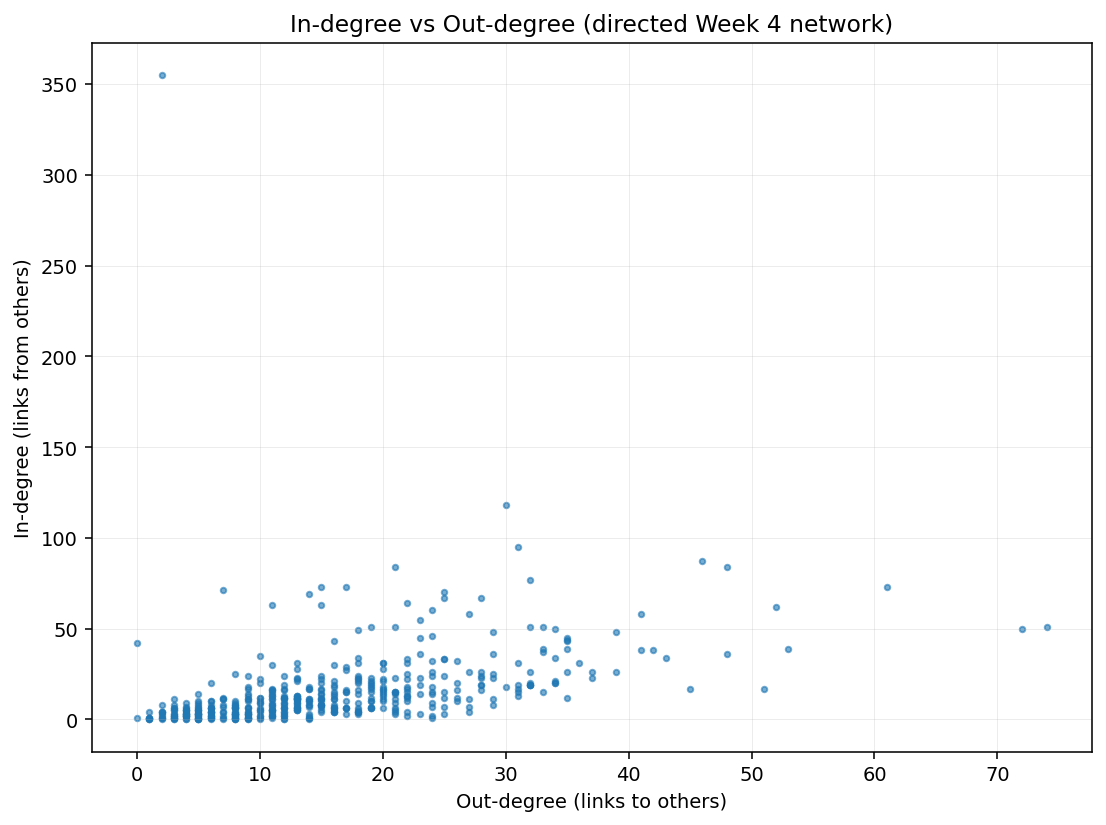

In [11]:
# Data arrays
nodes = list(H.nodes())
x_out = np.array([out_deg[n] for n in nodes], dtype=float)
y_in  = np.array([in_deg[n]  for n in nodes], dtype=float)

fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(x_out, y_in, s=8, alpha=0.6)
ax.set_xlabel("Out-degree (links to others)")
ax.set_ylabel("In-degree (links from others)")
ax.set_title("In-degree vs Out-degree (directed Week 4 network)")
ax.grid(True, linewidth=0.3, alpha=0.4)
plt.tight_layout()
plt.show()


Points along the diagonal have balanced in/out activity, while vertical outliers indicate “popular” targets (many incoming links) that don’t link out as much. Horizontal outliers act like “broad linkers” (many outgoing links) with limited visibility (few incoming links). Any heavy upper tail suggests a few highly referenced artists; a horizontal spread at low in-degree can indicate list-like/link-rich pages.

In [12]:
# Quantile-based thresholds (tweak if needed)
q_hi = 0.90
q_lo = 0.10
thr_out_hi = np.quantile(x_out, q_hi)
thr_in_hi  = np.quantile(y_in,  q_hi)
thr_out_lo = np.quantile(x_out, q_lo)
thr_in_lo  = np.quantile(y_in,  q_lo)

hi_out_lo_in = [n for n in nodes if out_deg[n] >= thr_out_hi and in_deg[n] <= thr_in_lo]
hi_in_lo_out = [n for n in nodes if in_deg[n]  >= thr_in_hi  and out_deg[n] <= thr_out_lo]

def preview(title, lst, k=15, sortkey=None, reverse=True):
    print(f"\n{title} (showing up to {k}, thresholds: out≥{thr_out_hi:.0f}/in≤{thr_in_lo:.0f} or vice versa)")
    if sortkey is None:
        sortkey = lambda n: (out_deg[n] - in_deg[n])
    for n in sorted(lst, key=sortkey, reverse=reverse)[:k]:
        print(f"  - {n:30s}  out={out_deg[n]:3d}  in={in_deg[n]:3d}  {wiki_url(n)}")

preview("High OUT-degree & Low IN-degree", hi_out_lo_in, sortkey=lambda n: out_deg[n]-in_deg[n])
preview("High IN-degree & Low OUT-degree", hi_in_lo_out, sortkey=lambda n: in_deg[n]-out_deg[n])



High OUT-degree & Low IN-degree (showing up to 15, thresholds: out≥30/in≤1 or vice versa)

High IN-degree & Low OUT-degree (showing up to 15, thresholds: out≥30/in≤1 or vice versa)
  - AllMusic                        out=  2  in=355  https://en.wikipedia.org/wiki/AllMusic
  - AC/DC                           out=  0  in= 42  https://en.wikipedia.org/wiki/AC/DC


• High out, low in: often “link-rich” pages—broad overviews, supergroups listing many members/associated acts, or very active collaborators who reference many others but aren’t equally referenced back.

• High in, low out: frequently iconic or central artists—many pages mention them, but their own page may be biographical and not link out extensively beyond essentials.

- Reasons for in-links: fame/centrality; historical influence; many others cite them as “associated acts,” inspiration, or members; covers and tributes; shared producers/labels that cause many pages to reference them.

- Reasons for out-links: discographies referencing collaborators; supergroups/membership lists; pages that enumerate influences/associated acts; editorial style (some pages link generously).

- Differences between in- and out-links: in-links reflect how others contextualize an artist (recognition/centrality), while out-links reflect how that page curates relationships (editorial breadth). Thus, high in-degree nodes need not be prolific linkers, and vice versa.

# Part B:  Advanced tools 

> **Video lecture**: *Network measures*. There's an updated video below, and if you can't get enough, you can watch the original version from 2015 [here](https://www.youtube.com/watch?v=0uAYpOqVHCU).

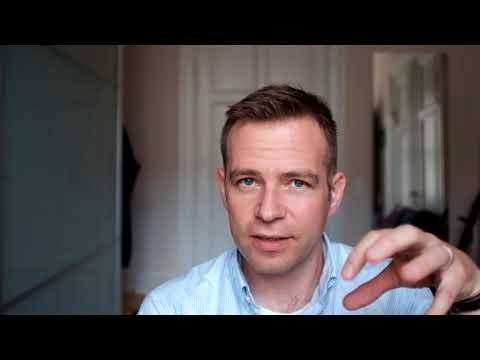

In [1]:
from IPython.display import YouTubeVideo
YouTubeVideo("IOWXZFOyk9Y", width=800, height=450)

*Exercise 3:* Last time we visually analyzed (plotted) the degree distributions of our network. Now, let's analyze it using some of the tools from previous lectures. For this exercise we are going to look at the *directed* graph (rememeber, we asked you to keep one?).

> 1. What are the average, median, mode, minimum and maximum value of the in-degree? And of the out-degree? How do you intepret the results?
> 2. Let's also look at the *[exponent of the degree distribution](http://networksciencebook.com/chapter/4#degree-exponent)* 
>    * To calculate it, you can install [`powerlaw`](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0085777) package (I could not install in conda, so I used `pip install powerlaw`)
>    * Use `powerlaw.Fit(degree).alpha` for fitting
>    * Find the degree exponent for in-, out- and total- degree distribution. Think about what you learned in the book - what does each exponent say about our network?
>    * When analyzing the plots of in- and out- degree distribution last week, did you come up to the same conclusions?
>    * Reflect on the whole power-law thing. Are the degree distributions even power laws? Could a log-normal or exponential distribution be better? How would you find out what the right function to describe the various degree distributions are? 
>    * A long time ago, a group of scientists analyzed the network spanned by **all** of Wikipedia (the paper is called [Wikipedias: Collaborative web-based encyclopedias as complex networks](https://journals.aps.org/pre/abstract/10.1103/PhysRevE.74.016115); to access this paper, use findit.dtu.dk or read the preprint on [arXiv](https://arxiv.org/abs/physics/0602149)). Do your findings correspond to the results described in Chapter **III.A** of that paper? If not, try to give your explanation of why? 
> 3. Plot a heatmap [(Hint here)](https://stackoverflow.com/questions/2369492/generate-a-heatmap-in-matplotlib-using-a-scatter-data-set) of the the in- versus out- degree for all characters. Zoom in on just the in-degree $[0,20]$ and out-degree $[0,20]$ area of the plot. What is the advantage of using a heatmap over the scatter plot from the previous Exercise (especially for understanding what's going on in this area)?
> 4. Why do you think I want you guys to use a directed graph? Are there questions we can ask using the directed graph that are not possible to answer in the undirected version? Which questions? Can you think of examples when the in/out distinction doesn't matter.
> 5. We have one more metric that we have used, but not investigated so far. The node-attribute `length_of_content`. There are two things to look at.
>    * Firstly, we can verify that more text means more links. If that's true the length should correlate with out-degree. Does it? 
>    * Secondly, and more interestingly, it could be that longer texts means *more famous* characters. And that means more in-links. 
>    * How should you test this? Well, here you are allowed to be **creative**. You may choose the method of your liking to study this question (e.g. look at it visually, test the correlation using [spearman](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.spearmanr.html) or [pearson](https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.stats.pearsonr.html) correlations, fit a curve to the data, you decide). Are both questions true? If yes, which phenomenon is stronger? Explain your results in your own words.

In [13]:
import os, pickle, math, statistics
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

np.random.seed(42)
plt.rcParams["figure.dpi"] = 140

# Load the directed graph saved from Week 4
graph_path = "rock_performers_LWCC.gpickle"
assert os.path.exists(graph_path), f"Missing {graph_path}. Re-run Week 4's save cell."

with open(graph_path, "rb") as f:
    H = pickle.load(f)

assert H.is_directed(), "This exercise needs the *directed* graph from Week 4."
print(f"Loaded H: |V|={H.number_of_nodes()}, |E|={H.number_of_edges()}, directed={H.is_directed()}")

# Degree dictionaries
in_deg  = dict(H.in_degree())
out_deg = dict(H.out_degree())
tot_deg = {n: in_deg[n] + out_deg[n] for n in H.nodes()}

# Node attribute for text length — accept either name and add an alias for consistency
for n, data in H.nodes(data=True):
    if "length_of_content" not in data:
        data["length_of_content"] = data.get("content_length", 0)

length = np.array([H.nodes[n].get("length_of_content", 0) for n in H.nodes()], dtype=float)

# Arrays for convenience
nodes = list(H.nodes())
in_arr  = np.array([in_deg[n]  for n in nodes], dtype=int)
out_arr = np.array([out_deg[n] for n in nodes], dtype=int)
tot_arr = in_arr + out_arr

print("Sanity check:",
      f"in-degree sum={in_arr.sum()} equals out-degree sum={out_arr.sum()}?",
      in_arr.sum() == out_arr.sum())

Loaded H: |V|=483, |E|=7587, directed=True
Sanity check: in-degree sum=7587 equals out-degree sum=7587? True


#### 2) Q1 — Summary stats for in/out degree

In [14]:
def describe(x):
    # x is a 1D numpy array of ints
    return dict(
        mean=float(x.mean()),
        median=float(np.median(x)),
        modes=statistics.multimode(x.tolist()),
        minimum=int(x.min()),
        maximum=int(x.max())
    )

stats_in  = describe(in_arr)
stats_out = describe(out_arr)

print("In-degree stats:",  stats_in)
print("Out-degree stats:", stats_out)


In-degree stats: {'mean': 15.70807453416149, 'median': 10.0, 'modes': [6], 'minimum': 0, 'maximum': 355}
Out-degree stats: {'mean': 15.70807453416149, 'median': 13.0, 'modes': [13], 'minimum': 0, 'maximum': 74}


#### 3) Q2 — Degree exponents (power law?) and model comparisons

In [16]:
import powerlaw

def fit_exponent(deg_array, name, discrete=True, xmin=None):
    # Filter non-positive degrees; power laws are defined for k >= 1.
    data = deg_array[deg_array >= 1]
    if data.size == 0:
        return dict(name=name, alpha=np.nan, xmin=np.nan, n=0, note="no k>=1")
    fit = powerlaw.Fit(data, discrete=discrete, xmin=xmin)
    alpha = fit.alpha
    return dict(name=name, alpha=float(alpha), xmin=float(fit.xmin), n=int(data.size), fit=fit)

res_in  = fit_exponent(in_arr,  "in-degree")
res_out = fit_exponent(out_arr, "out-degree")
res_tot = fit_exponent(tot_arr, "total-degree")

for r in (res_in, res_out, res_tot):
    print(f"{r['name']:12s} alpha={r['alpha']:.3f}  xmin={r['xmin']:.1f}  n(k>=1)={r['n']}")

# Optional: compare alternatives (power law vs lognormal / exponential)
def compare_models(fit):
    if fit is None: 
        return
    for dist in ["lognormal", "exponential"]:
        R, p = fit.distribution_compare("power_law", dist)
        print(f"Compare power_law vs {dist:11s}:  loglikelihood ratio R={R:.3f},  p={p:.3g}")

print("\nModel comparisons (lower p suggests a meaningful difference; sign of R favors one model):")
compare_models(res_in.get("fit"))
compare_models(res_out.get("fit"))
compare_models(res_tot.get("fit"))

Calculating best minimal value for power law fit
c:\Users\Leuro\anaconda3\envs\ML\Lib\site-packages\powerlaw.py:699: RuntimeWarning: invalid value encountered in divide
  (CDF_diff**2) /
Calculating best minimal value for power law fit
c:\Users\Leuro\anaconda3\envs\ML\Lib\site-packages\powerlaw.py:699: RuntimeWarning: divide by zero encountered in divide
  (CDF_diff**2) /
Calculating best minimal value for power law fit


in-degree    alpha=2.523  xmin=15.0  n(k>=1)=460
out-degree   alpha=3.874  xmin=20.0  n(k>=1)=481
total-degree alpha=2.945  xmin=31.0  n(k>=1)=483

Model comparisons (lower p suggests a meaningful difference; sign of R favors one model):
Compare power_law vs lognormal  :  loglikelihood ratio R=-4.144,  p=0.127
Compare power_law vs exponential:  loglikelihood ratio R=6.464,  p=0.581
Compare power_law vs lognormal  :  loglikelihood ratio R=-4.723,  p=0.075
Compare power_law vs exponential:  loglikelihood ratio R=-4.609,  p=0.0815
Compare power_law vs lognormal  :  loglikelihood ratio R=-6.057,  p=0.0701
Compare power_law vs exponential:  loglikelihood ratio R=-3.145,  p=0.66


### Q3 — Heatmap of in vs out degree (zoom to [0,20] × [0,20])

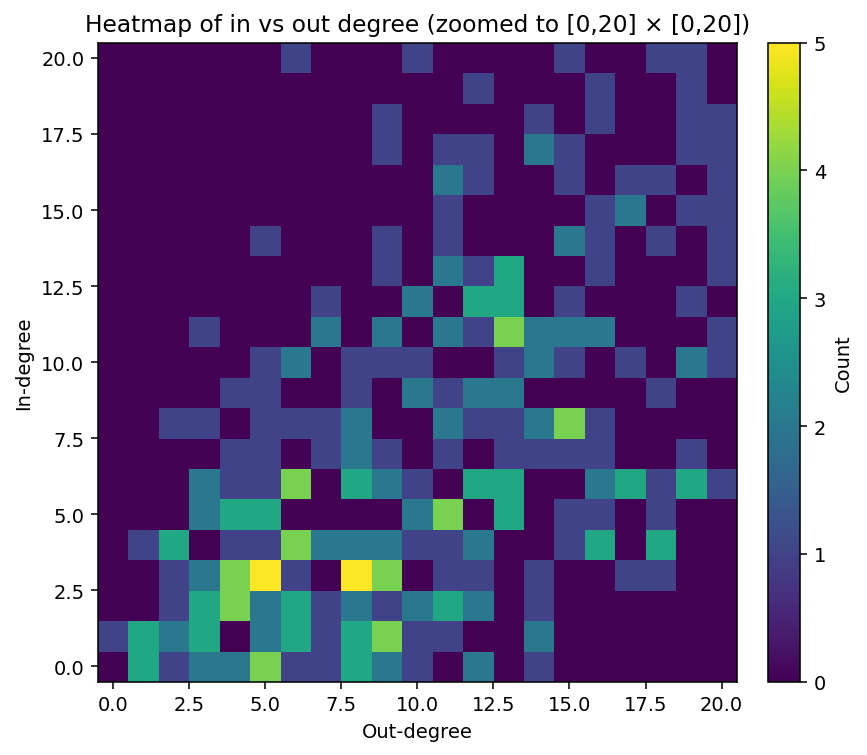

In [17]:
# 2D histogram over the zoomed window
xmax = 20
ymax = 20
mask = (out_arr <= xmax) & (in_arr <= ymax)
x = out_arr[mask]
y = in_arr[mask]

bins = (np.arange(xmax+2)-0.5, np.arange(ymax+2)-0.5)  # integer-centered bins
H2d, xedges, yedges = np.histogram2d(x, y, bins=bins)

fig, ax = plt.subplots(figsize=(6.5, 5.5))
im = ax.imshow(
    H2d.T,
    origin="lower",
    extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
    aspect="equal"
)
plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04).set_label("Count")
ax.set_xlim(-0.5, xmax+0.5)
ax.set_ylim(-0.5, ymax+0.5)
ax.set_xlabel("Out-degree")
ax.set_ylabel("In-degree")
ax.set_title("Heatmap of in vs out degree (zoomed to [0,20] × [0,20])")
plt.tight_layout()
plt.show()


### 5) Q4 — Why directed?
- Directed edges let us separate attention/recognition (in-links) from linking behavior/editorial style (out-links).

- Questions only answerable with direction: “Who are authoritative targets?” (high in), “Who are prolific linkers/lists?” (high out), “Are there reciprocal ties?”, “What fraction of edges are asymmetric?”, “Is there assortativity by in/out roles?”.

- When direction doesn’t matter: undirected community structure or path-based connectivity where reciprocity isn’t central.

Length vs OUT-degree  — Pearson r=0.636 (p=4.57e-56), Spearman ρ=0.678 (p=2.52e-66)
Length vs IN-degree   — Pearson r=0.449 (p=2.50e-25), Spearman ρ=0.626 (p=7.59e-54)


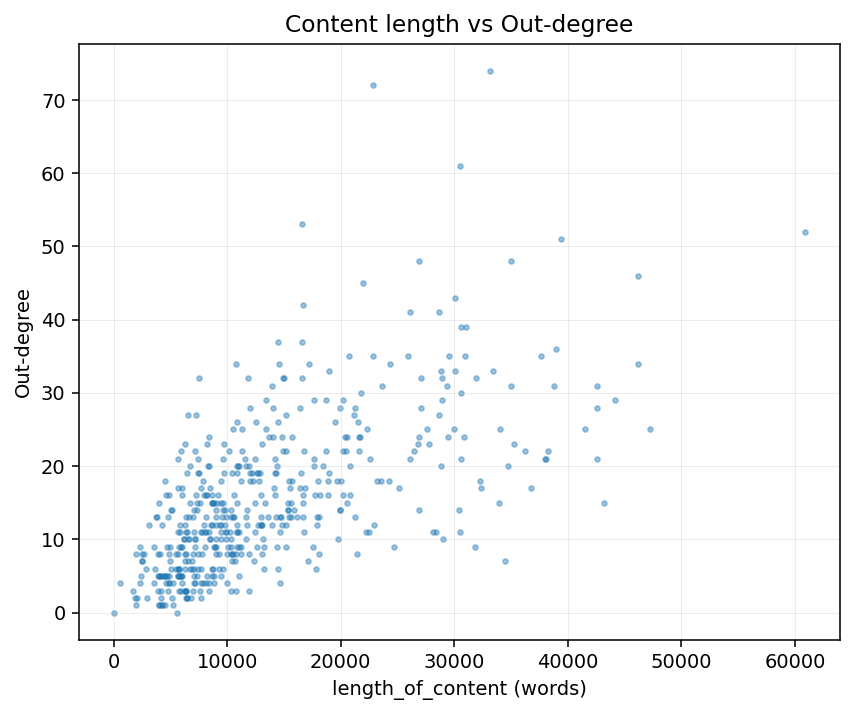

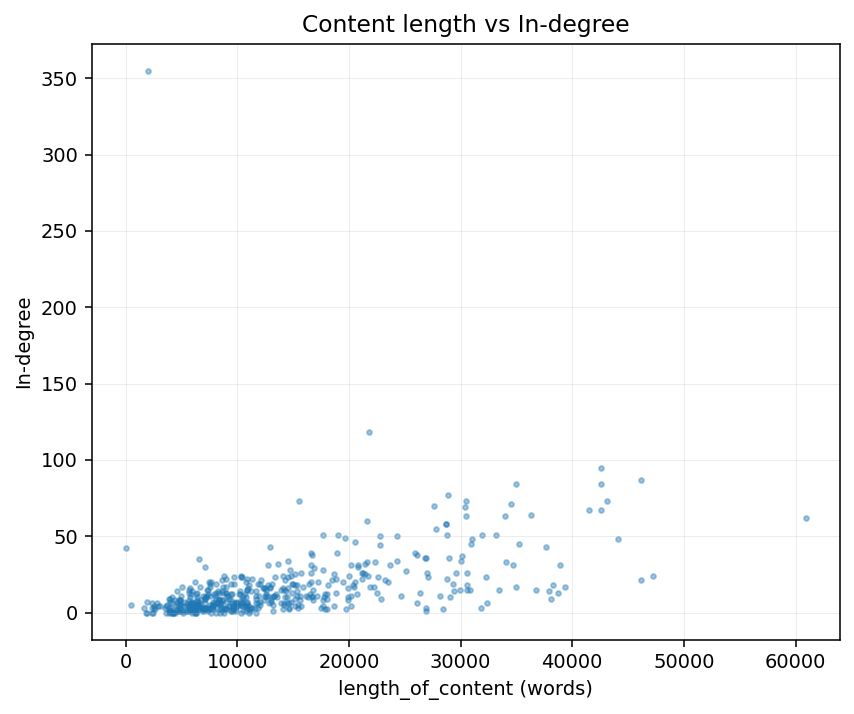

Stronger *rank* association (by |Spearman|) appears with: out-degree.


In [19]:
from scipy.stats import pearsonr, spearmanr
pearson = "scipy"; spearman = "scipy"

def pearson_corr(x, y):
    if pearson == "scipy":
        r, p = pearsonr(x, y); return float(r), float(p)
    # fallback with NumPy (no p-value)
    r = np.corrcoef(x, y)[0,1]; return float(r), np.nan

def spearman_corr(x, y):
    if spearman == "scipy":
        r, p = spearmanr(x, y); return float(r), float(p)
    if spearman == "pandas":
        import pandas as pd
        rx = pd.Series(x).rank(method="average")
        ry = pd.Series(y).rank(method="average")
        r = np.corrcoef(rx, ry)[0,1]; return float(r), np.nan
    return np.nan, np.nan

# Correlations
rP_out, pP_out = pearson_corr(length, out_arr)
rS_out, pS_out = spearman_corr(length, out_arr)

rP_in,  pP_in  = pearson_corr(length, in_arr)
rS_in,  pS_in  = spearman_corr(length, in_arr)

print("Length vs OUT-degree  — Pearson r={:.3f} (p={}), Spearman ρ={:.3f} (p={})"
      .format(rP_out, "NA" if np.isnan(pP_out) else f"{pP_out:.2e}", rS_out, "NA" if np.isnan(pS_out) else f"{pS_out:.2e}"))
print("Length vs IN-degree   — Pearson r={:.3f} (p={}), Spearman ρ={:.3f} (p={})"
      .format(rP_in,  "NA" if np.isnan(pP_in)  else f"{pP_in:.2e}",  rS_in,  "NA" if np.isnan(pS_in)  else f"{pS_in:.2e}"))

# Quick visual checks (two separate figures, trimmed axes to avoid extreme leverage)
fig, ax = plt.subplots(figsize=(6.2, 5.2))
ax.scatter(length, out_arr, s=6, alpha=0.4)
ax.set_xlabel("length_of_content (words)")
ax.set_ylabel("Out-degree")
ax.set_title("Content length vs Out-degree")
ax.grid(True, linewidth=0.3, alpha=0.4)
plt.tight_layout(); plt.show()

fig, ax = plt.subplots(figsize=(6.2, 5.2))
ax.scatter(length, in_arr, s=6, alpha=0.4)
ax.set_xlabel("length_of_content (words)")
ax.set_ylabel("In-degree")
ax.set_title("Content length vs In-degree")
ax.grid(True, linewidth=0.3, alpha=0.4)
plt.tight_layout(); plt.show()

# A simple “which is stronger?” indicator
which = "out-degree" if abs(rS_out) > abs(rS_in) else "in-degree"
print(f"Stronger *rank* association (by |Spearman|) appears with: {which}.")

*Exercise 4:* Centralities, assortativity and more.

Earlier, we found the most connected nodes (using degree centrality). 

Now let's dig in and try to understand more about the network using more advanced features. 

**Note**: Not all of the measures we'll be considering below are defined for directed graphs. Only use the undirected graph when explicitly stated in the exercise. 
> 1. Find the 5 most central characters according to degree centrality. 
> 1. Find the 5 most central characters according to betweenness centrality. 
>    * Repeat Exercise 1 (plotting the network). However, this time use *betweenness centrality* to define the size of the node.
>    * What role do you imagine characters with high wikipedia graph betweenness centrality play in the network? 
> 2. Find the 5 most central characters according to eigenvector centrality. Calculate centrality corresponding to both in- and out-edges (see NetworkX documentation for details). 
>    * Repeat Exercise 1 one final time (depending on which visualization method you liked the most). However, this time use eigenvector centrality to define the size of the node.
>    * What role do you imagine characters with high wikipedia graph eigenvector centrality play? Describe what is different about betweenness centrality and eigenvector centrality using your visualizations as examples.
> 3. Plot the betweenness centrality of nodes vs their degree centrality. Is there a correlation between the two? Did you expect that? Why? 
>     * Repeat the scatter plot using eigenvector centrality instead of betweenness centrality. Do you observe any difference relative to above? Why?
> 4. Is the undirected version of the graph [assortative](https://en.wikipedia.org/wiki/Assortativity) with respect to degree? (e.g. do high-degree characters tend to link to other high-degree characters, and low-degree characters to other low-degree characters?). Provide an interpretation of your answer.
> 5. Is the undirected version of the graph [assortative](https://en.wikipedia.org/wiki/Assortativity) with respect do the `length_of_content` nodal properties? (e.g. do characters with long Wikipedia pages tend to link to other charakters with long Wiki-pages, and *vice versa*?.
>      * Hint: Use [this function](https://networkx.github.io/documentation/stable/reference/algorithms/generated/networkx.algorithms.assortativity.attribute_assortativity_coefficient.html#networkx.algorithms.assortativity.attribute_assortativity_coefficient). Provide an interpretation of your answer.
> 6. What is the average shortest path length? Is it similar to the one of a random graph with the same number of nodes $N$  and probablity of connection $p$?
>    * Take a look at the *distribution* of shortest paths for the two networks (create a histogram for each network) to better compare and contrast. Explain what you see in your own words.

### Q1 — Top-5 by degree centrality (directed graph)

In [20]:
def topk_dict(d, k=5):
    return sorted(d.items(), key=lambda x: x[1], reverse=True)[:k]

# ForceAtlas2 layout (NetworkX 3.5)
pos = nx.forceatlas2_layout(
    G,
    max_iter=800,
    dissuade_hubs=True,
    scaling_ratio=2.5,
    gravity=1.0,
    seed=42
)
deg_cent = nx.degree_centrality(H)  # directed total (in+out)
print("Top 5 — degree centrality (directed total):")
for n, v in topk_dict(deg_cent, 5):
    print(f"{v:.4f}  {n}")


Top 5 — degree centrality (directed total):
0.7407  AllMusic
0.3071  Led_Zeppelin
0.2780  Black_Sabbath
0.2759  Queen_(band)
0.2739  Metallica


### Q2 — Top-5 by betweenness centrality (directed graph)

In [22]:
import os, pickle, math, statistics, itertools, random

N = H.number_of_nodes()
# Heuristic: approximate for large N
if N <= 3000:
    btw = nx.betweenness_centrality(H, normalized=True)
else:
    k = min(300, N)  # sample sources
    sources = random.sample(list(H.nodes()), k)
    btw = nx.betweenness_centrality(H, k=k, normalized=True, seed=42)

print("Top 5 — betweenness centrality (directed):")
for n, v in topk_dict(btw, 5):
    print(f"{v:.5f}  {n}")


Top 5 — betweenness centrality (directed):
0.04303  Deep_Purple
0.03866  Queen_(band)
0.03668  Alice_in_Chains
0.03528  Guns_N'_Roses
0.03435  Led_Zeppelin


### undirected GCC with size = betweenness (from directed H)

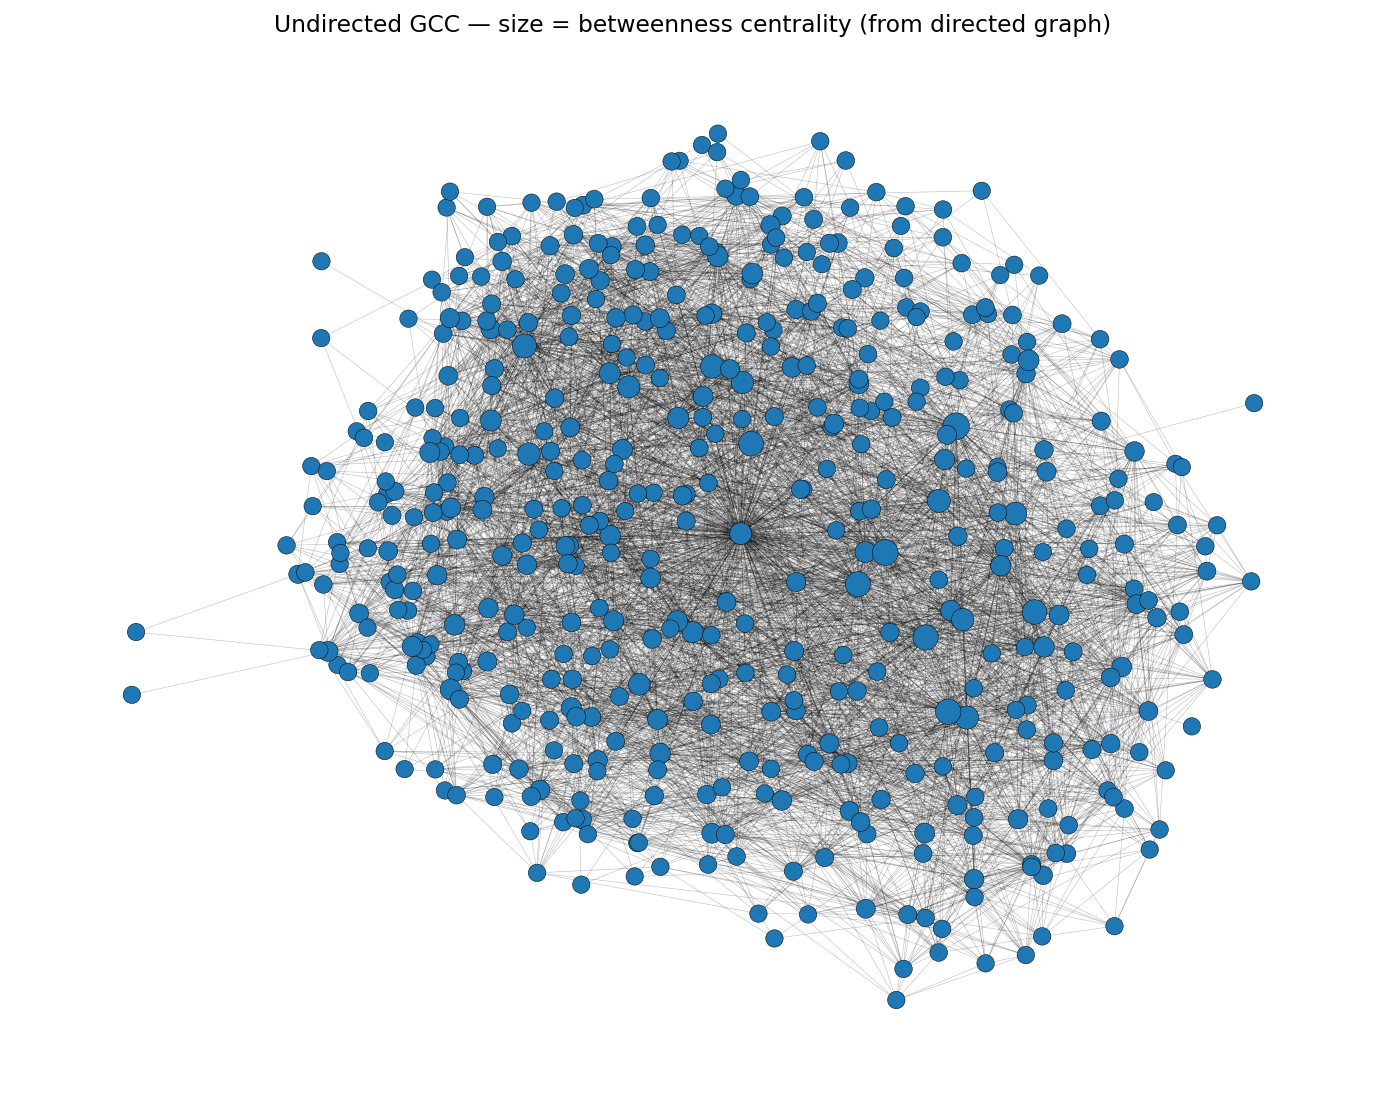

In [23]:
sizes = np.array([80 + 2500*btw.get(n, 0.0) for n in G.nodes()])  # scaled for visibility
fig, ax = plt.subplots(figsize=(10, 8))
nx.draw_networkx_edges(G, pos, ax=ax, width=0.3, alpha=0.25)
nx.draw_networkx_nodes(G, pos, ax=ax, node_size=sizes, linewidths=0.25, edgecolors="black")
ax.set_title("Undirected GCC — size = betweenness centrality (from directed graph)")
ax.axis("off")
plt.tight_layout(); plt.show()


(what high-betweenness “do”): Nodes large here often sit on bridges between clusters (control many shortest paths). In a Wikipedia-link context they may connect genres, eras, or scenes (e.g., supergroups, widely-collaborative artists, or pages that list/curate cross-community ties).

### Eigenvector centrality (directed “in” vs “out”)

In [24]:
# Work on the largest *strongly* connected component to ensure convergence if needed
scc_nodes = max(nx.strongly_connected_components(H), key=len)
Hs = H.subgraph(scc_nodes).copy()

# Out-oriented eigenvector (default orientation)
ev_out = nx.eigenvector_centrality(Hs, max_iter=1000, tol=1e-06)
# In-oriented eigenvector via reversed graph
ev_in  = nx.eigenvector_centrality(Hs.reverse(), max_iter=1000, tol=1e-06)

print("Top 5 — eigenvector centrality (OUT-oriented):")
for n, v in topk_dict(ev_out, 5):
    print(f"{v:.5f}  {n}")

print("\nTop 5 — eigenvector centrality (IN-oriented):")
for n, v in topk_dict(ev_in, 5):
    print(f"{v:.5f}  {n}")


Top 5 — eigenvector centrality (OUT-oriented):
0.41147  AllMusic
0.20500  Led_Zeppelin
0.17765  Black_Sabbath
0.16784  Queen_(band)
0.16737  Metallica

Top 5 — eigenvector centrality (IN-oriented):
0.20464  Alice_in_Chains
0.17513  Deep_Purple
0.17411  Black_Sabbath
0.16281  Metallica
0.15965  Megadeth


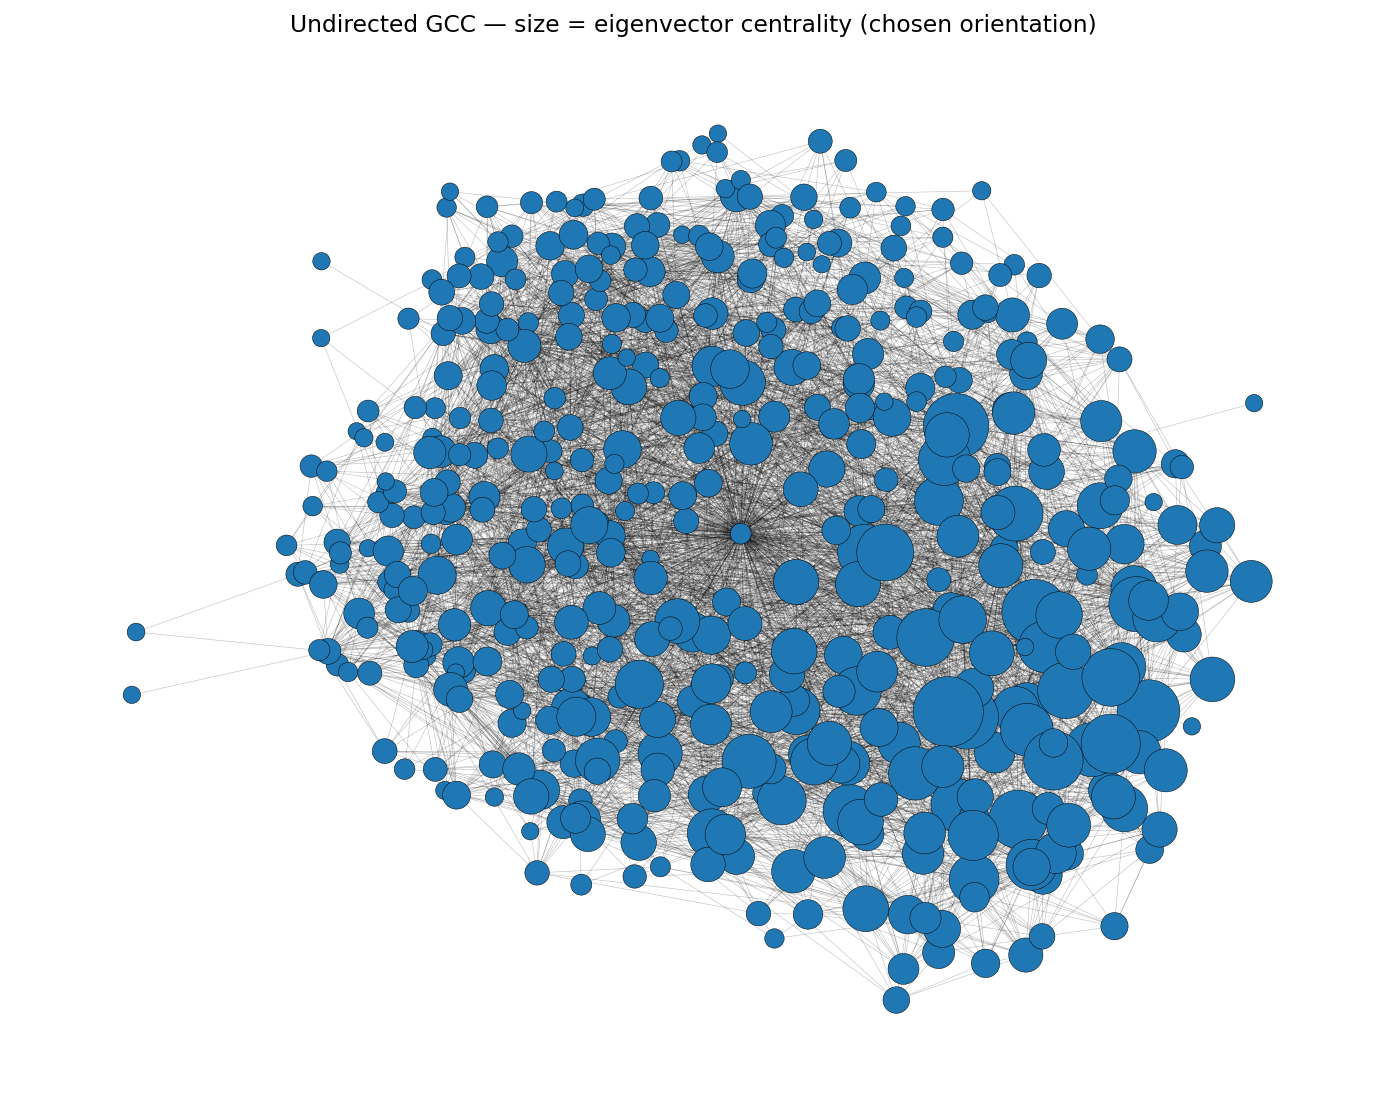

In [25]:
# Choose which to visualize:
to_show = ev_in  # or ev_out

# Map scores from Hs to G (missing nodes get 0)
scores = np.array([to_show.get(n, 0.0) for n in G.nodes()])
sizes = 80 + 6000*scores  # scale for visibility

fig, ax = plt.subplots(figsize=(10, 8))
nx.draw_networkx_edges(G, pos, ax=ax, width=0.3, alpha=0.25)
nx.draw_networkx_nodes(G, pos, ax=ax, node_size=sizes, linewidths=0.25, edgecolors="black")
ax.set_title("Undirected GCC — size = eigenvector centrality (chosen orientation)")
ax.axis("off")
plt.tight_layout(); plt.show()


Betweenness elevates brokers on paths between regions (structural bridges); eigenvector elevates nodes embedded within well-connected high-status neighborhoods. A node can be huge in betweenness yet modest in eigenvector (a bridge between two communities), or vice versa (deep inside a dense “elite” cluster).

### Centrality relationships

Scatter: betweenness vs degree (directed measures)

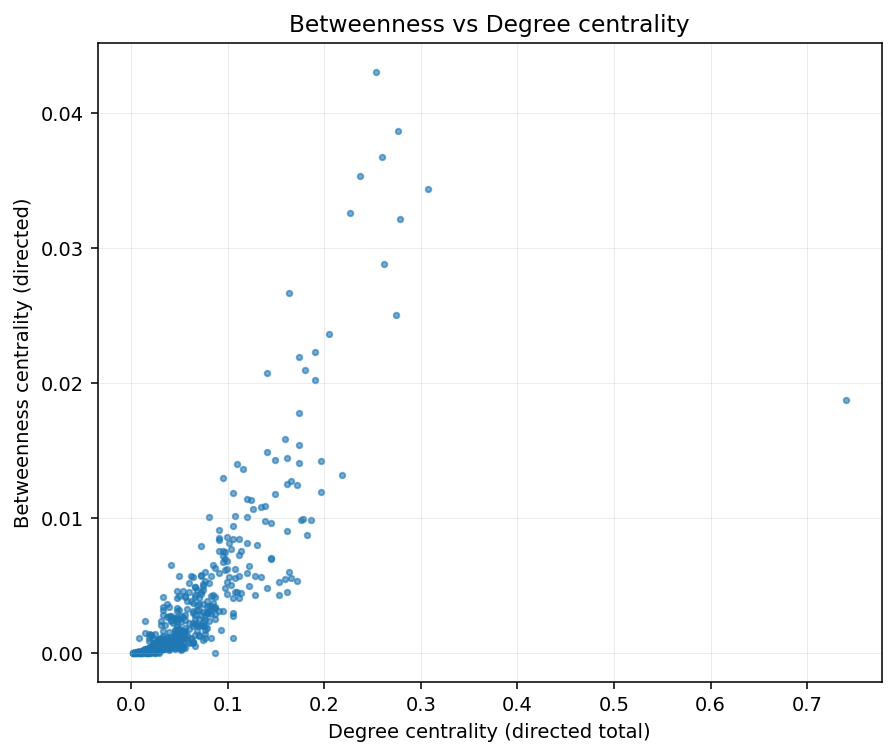

In [26]:
deg_cent_arr = np.array([deg_cent[n] for n in H.nodes()])
btw_arr      = np.array([btw.get(n, 0.0) for n in H.nodes()])

fig, ax = plt.subplots(figsize=(6.5, 5.5))
ax.scatter(deg_cent_arr, btw_arr, s=8, alpha=0.6)
ax.set_xlabel("Degree centrality (directed total)")
ax.set_ylabel("Betweenness centrality (directed)")
ax.set_title("Betweenness vs Degree centrality")
ax.grid(True, linewidth=0.3, alpha=0.4)
plt.tight_layout(); plt.show()


Scatter: eigenvector vs degree (pick in- or out-oriented)

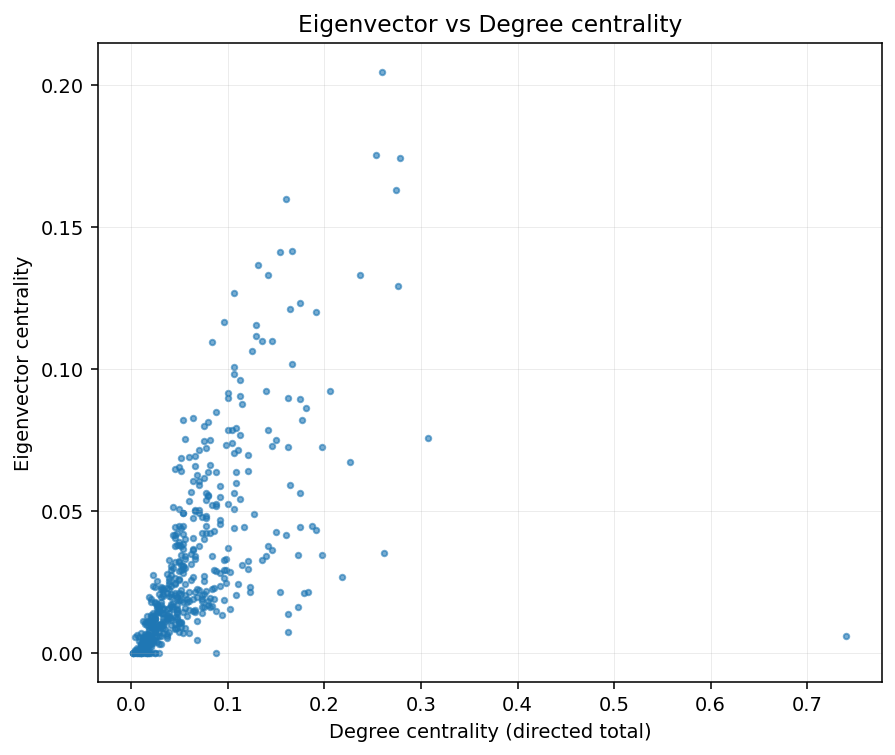

In [27]:
# Align to the full node set (zeros if outside Hs)
ev_chosen = ev_in  # or ev_out
ev_vec = np.array([ev_chosen.get(n, 0.0) for n in H.nodes()])

fig, ax = plt.subplots(figsize=(6.5, 5.5))
ax.scatter(deg_cent_arr, ev_vec, s=8, alpha=0.6)
ax.set_xlabel("Degree centrality (directed total)")
ax.set_ylabel("Eigenvector centrality")
ax.set_title("Eigenvector vs Degree centrality")
ax.grid(True, linewidth=0.3, alpha=0.4)
plt.tight_layout(); plt.show()


### Part 4 — Assortativity (undirected)
10) Q4 — Degree assortativity (undirected GCC)

In [28]:
deg_r = nx.degree_assortativity_coefficient(G)  # Pearson correlation of degrees at either end of edges
print(f"Degree assortativity (undirected GCC): r = {deg_r:.3f}")


Degree assortativity (undirected GCC): r = -0.091


- r>0: high-degree nodes tend to connect to high-degree (assortative).
- r<0: high-degree connect to low-degree (disassortative).

In many technological/information networks, slight disassortativity is common; music/artist networks vary by construction.

11) Q5 — Attribute assortativity for length_of_content (undirected GCC)

Two views: numeric (preferred) and categorical bins (as per hint).

In [29]:
# Numeric assortativity: Pearson r between lengths at edge endpoints
len_num_r = nx.numeric_assortativity_coefficient(G, "length_of_content")
print(f"Numeric assortativity (length_of_content): r = {len_num_r:.3f}")

# Categorical: bin lengths (quartiles), then attribute assortativity
lengths = np.array([G.nodes[n]["length_of_content"] for n in G.nodes()])
q = np.quantile(lengths, [0.25, 0.5, 0.75])
def len_bin(v):
    return 0 if v <= q[0] else 1 if v <= q[1] else 2 if v <= q[2] else 3

for n in G.nodes():
    G.nodes[n]["len_bin"] = len_bin(G.nodes[n]["length_of_content"])

len_cat_r = nx.attribute_assortativity_coefficient(G, "len_bin")
print(f"Categorical assortativity (len_bin quartiles): r = {len_cat_r:.3f}")


Numeric assortativity (length_of_content): r = 0.068
Categorical assortativity (len_bin quartiles): r = 0.031


A positive value suggests “long-page artists tend to connect to other long-page artists” (and short to short). If near zero, page length is weakly mixed along edges.

### Part 5 — Shortest paths (undirected)
12) Q6 — Average shortest path length and ER baseline

In [30]:
# Avg shortest path on the undirected GCC
asp_G = nx.average_shortest_path_length(G)
print(f"Avg shortest path length (Undirected GCC): {asp_G:.3f}")

# ER graph with same N and p ~ 2M/(N*(N-1))
N = G.number_of_nodes()
M = G.number_of_edges()
p = (2*M) / (N*(N-1))
ER = nx.gnp_random_graph(N, p, seed=42)

# Compare on the LCC of ER to avoid disconnected cases
ER_cc = ER.subgraph(max(nx.connected_components(ER), key=len)).copy()
asp_ER = nx.average_shortest_path_length(ER_cc)
print(f"Avg shortest path length (ER LCC, N={ER_cc.number_of_nodes()}): {asp_ER:.3f}")


Avg shortest path length (Undirected GCC): 2.168
Avg shortest path length (ER LCC, N=483): 2.180


### 13) Distributions of shortest path lengths (histograms)

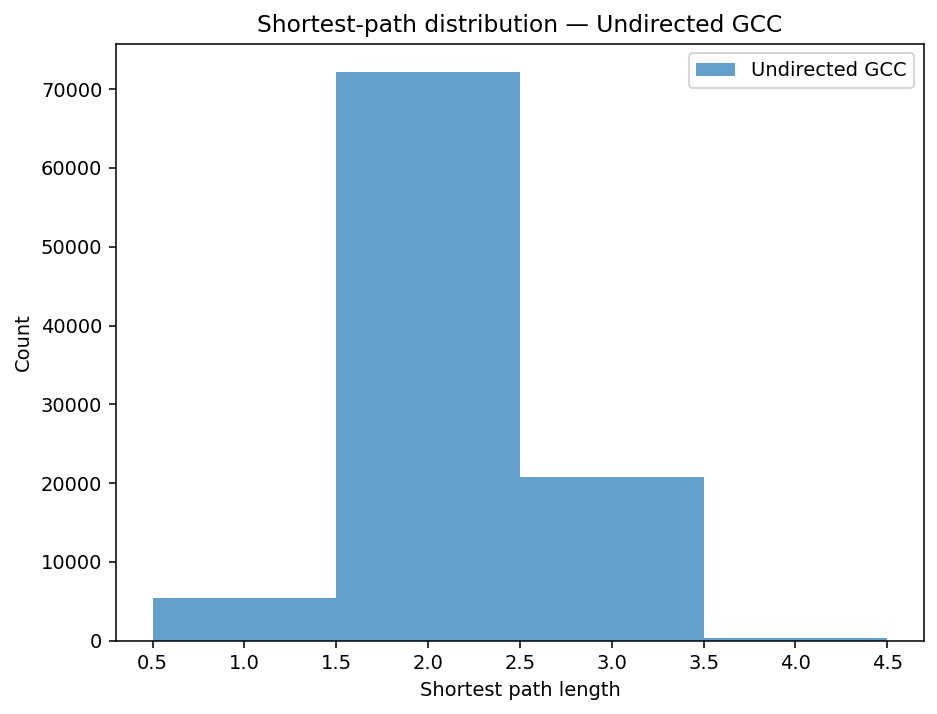

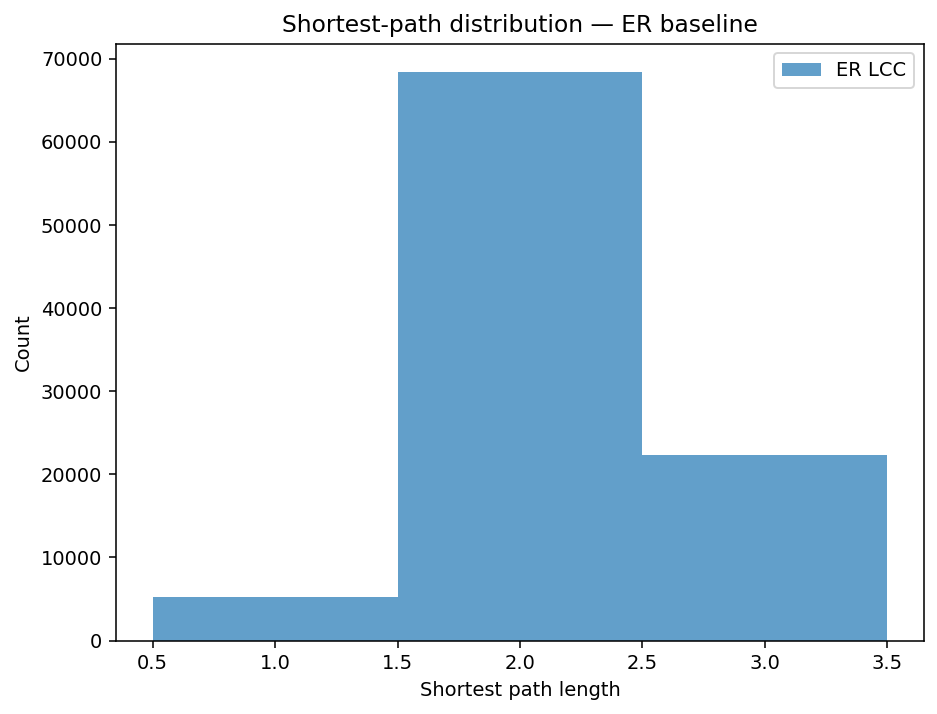

In [31]:
def pair_distance_hist(G_, S=400):
    nodes = list(G_.nodes())
    if len(nodes) <= S:
        sources = nodes
    else:
        sources = random.sample(nodes, S)
    dists = []
    for s in sources:
        lengths = nx.single_source_shortest_path_length(G_, s)
        # collect only s<t to avoid double counting
        for t, d in lengths.items():
            if t != s and (s < t):
                dists.append(d)
    return np.array(dists, dtype=int)

d_G  = pair_distance_hist(G,  S=400)
d_ER = pair_distance_hist(ER_cc, S=400)

fig, ax = plt.subplots(figsize=(6.8, 5.2))
ax.hist(d_G, bins=np.arange(d_G.min(), d_G.max()+2)-0.5, alpha=0.7, label="Undirected GCC")
ax.set_xlabel("Shortest path length")
ax.set_ylabel("Count")
ax.set_title("Shortest-path distribution — Undirected GCC")
ax.legend()
plt.tight_layout(); plt.show()

fig, ax = plt.subplots(figsize=(6.8, 5.2))
ax.hist(d_ER, bins=np.arange(d_ER.min(), d_ER.max()+2)-0.5, alpha=0.7, label="ER LCC")
ax.set_xlabel("Shortest path length")
ax.set_ylabel("Count")
ax.set_title("Shortest-path distribution — ER baseline")
ax.legend()
plt.tight_layout(); plt.show()


Real networks often show shorter paths than ER at the same 
𝑝
p when strong community structure plus hubs reduce distances (small-world effect). Compare peaks and tails: a longer right tail in ER indicates more pairs requiring many steps.

# Part C: Backbones and Network Visualization 

One method to clean up the "hairball"-looking networks, is known as the [backbone method](https://www.pnas.org/doi/10.1073/pnas.0808904106). Sometimes this method is also called the "disparity filter". I explain what it's all about in the video below.

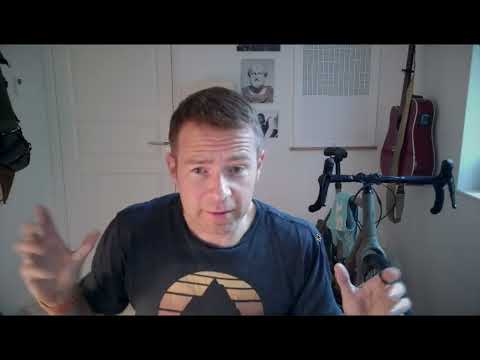

In [2]:
YouTubeVideo("GOvsrVulbsg", width=800, height=450)

There are [many backbone extraction algorithms](https://www.michelecoscia.com/?page_id=287), and I've chosen to talk about the *Disparity Filter* here, because it's the oldest and most commonly used method (so I though you should know about it). Plus, it'll probably be the relevant method for your project.

This choice, however, presents us with a problem: As I explain in the video, the Disparity Filter method *only works on weighted networks*. But our network does not have edge weights in any kind of natural way (since there's usually just a single link between two wiki pages). 


So to get rid of unimportant edges, we'll have to try something different. I present you with three possible methods below. For the first two ones, we'll add weights proportional to the [edge betweenness centrality](https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.centrality.edge_betweenness_centrality.html). The edge betweenness centrality is just like the node betweenness centrality that you know and love ... only that it's defined for *edges* instead of nodes.

We can create two new weighted networks based on the edge betweenness
 * **Weighted Network 1**: The ***undirected*** Rock Music Network (Giant Connected Component) but with edge weights proportional to the edge betweenness centrality (let's renormalize so that the lowest weight is equal to 1 and the highest weight is equal to 100).
 * **Weighted Network 2**: The ***undirected*** Rock Music Network  (Giant Connected Component) but with edge weights proportional to 1/(edge weight in Weighted Network 1).

The third strategy (resulting in **Weighted network 3**) is to use a method designed for extracting structure from undirected networks: The [**High-Salience Skeleton**](https://www.nature.com/articles/ncomms1847). It's implemented as part of [this backbone extraction package](https://www.michelecoscia.com/?page_id=287)


Now we're ready for the exercise.


*Exercise 5*: Visualizing the Network Backbone

> 1. Extract the network backbone for both Weighted Network 1, 2, and 3. You can implement the disparity filter yourself based on the [scientific paper](https://www.pnas.org/doi/10.1073/pnas.0808904106) or find an implentation on GitHub (there are several ones to choose from ... I like [this implementation](https://www.michelecoscia.com/?page_id=287), which also includes other interesting edge filters). Figure out how your particular backbone extractor works (you may have to inspect the code itself, these packages are not always well documented). Play around with values of $\alpha$ to get an aestetically pleasing visualization (but don't make the resulting network too sparse).
> 2. Plot the resulting three networks using ForceAtlas2, still sizing nodes according to total degree. No need to color them. If your backbone has some disconnected nodes, feel free to not plot them. And remember to calculate a new layout to see how the structure has changed.
> 3. Comment on your results
>    * Do you see any structures in the networks now? Inspect some nodes to get a sense of what the structures captures in the three networks. Describe your findings in your own words.
>    * Weighted network 1, 2, and 3 are very different. In 1 and 2, we have removed edges with low/high edge betweenness centrality respectively and HSH is based on shortest paths. What have the various filters done to the networks? Describe what you see visually, and your explain your thoughts on what we've done to the network structures.



One final thing. For now, the backbones are mostly for visualization. Especially because the edge weights are a bit artificial. Generally, it's not exactly clear what kind of information we get rid off when removing the non-backbone edges -- and in our case it's even less clear because I've made up two of the methods. Thus, we'll still do the exercises during the following weeks using the full network that preserves all of the connection information.


1. Create weighted networks

In [32]:
# Start from undirected GCC
G_und = H.to_undirected()
gcc = max(nx.connected_components(G_und), key=len)
G = G_und.subgraph(gcc).copy()

print(f"Base GCC: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges")

# --- Edge betweenness centrality ---
ebc = nx.edge_betweenness_centrality(G, normalized=True)

# Weighted Network 1: scale betweenness into [1, 100]
min_b, max_b = min(ebc.values()), max(ebc.values())
for u, v in G.edges():
    scaled = 1 + 99 * (ebc[(u, v)] - min_b) / (max_b - min_b)
    G[u][v]["w1"] = scaled

# Weighted Network 2: inverse
for u, v in G.edges():
    G[u][v]["w2"] = 1.0 / G[u][v]["w1"]

print("Added weights w1 (betweenness scaled) and w2 (inverse).")


Base GCC: 483 nodes, 6299 edges
Added weights w1 (betweenness scaled) and w2 (inverse).


2. High-Salience Skeleton (Weighted Network 3)

The High-Salience Skeleton (HSS) backbone extracts edges that appear frequently across shortest paths. We can compute it directly:

In [34]:
# Function to compute HSS backbone
def high_salience_skeleton(G):
    # Edge salience = fraction of shortest paths that pass through edge
    salience = {e: 0 for e in G.edges()}
    edge_set = set(G.edges())
    for source in G.nodes():
        sp = nx.single_source_shortest_path(G, source)
        for target, path in sp.items():
            for i in range(len(path) - 1):
                u, v = path[i], path[i+1]
                # For undirected graphs, edge may be stored as (u, v) or (v, u)
                if (u, v) in edge_set:
                    salience[(u, v)] += 1
                elif (v, u) in edge_set:
                    salience[(v, u)] += 1
                else:
                    # Should not happen if path is valid
                    pass
    # Normalize by number of nodes
    n = len(G)
    for e in salience:
        salience[e] /= n
    return salience

salience = high_salience_skeleton(G)
nx.set_edge_attributes(G, salience, "w3")
print("Computed High-Salience Skeleton weights (w3).")


Computed High-Salience Skeleton weights (w3).


3. Extract backbone networks

In [35]:
# Thresholds: play with alpha to adjust sparsity
alpha1, alpha2, alpha3 = 50, 0.02, 0.05

# Weighted Network 1 backbone
B1 = nx.Graph([(u, v, {"weight": d["w1"]}) for u, v, d in G.edges(data=True) if d["w1"] > alpha1])

# Weighted Network 2 backbone
B2 = nx.Graph([(u, v, {"weight": d["w2"]}) for u, v, d in G.edges(data=True) if d["w2"] > alpha2])

# Weighted Network 3 backbone (HSS)
B3 = nx.Graph([(u, v, {"weight": d["w3"]}) for u, v, d in G.edges(data=True) if d["w3"] > alpha3])

print(f"B1: {B1.number_of_nodes()} nodes, {B1.number_of_edges()} edges")
print(f"B2: {B2.number_of_nodes()} nodes, {B2.number_of_edges()} edges")
print(f"B3: {B3.number_of_nodes()} nodes, {B3.number_of_edges()} edges")


B1: 102 nodes, 98 edges
B2: 478 nodes, 6201 edges
B3: 483 nodes, 4190 edges


4. Visualize with ForceAtlas2 layout

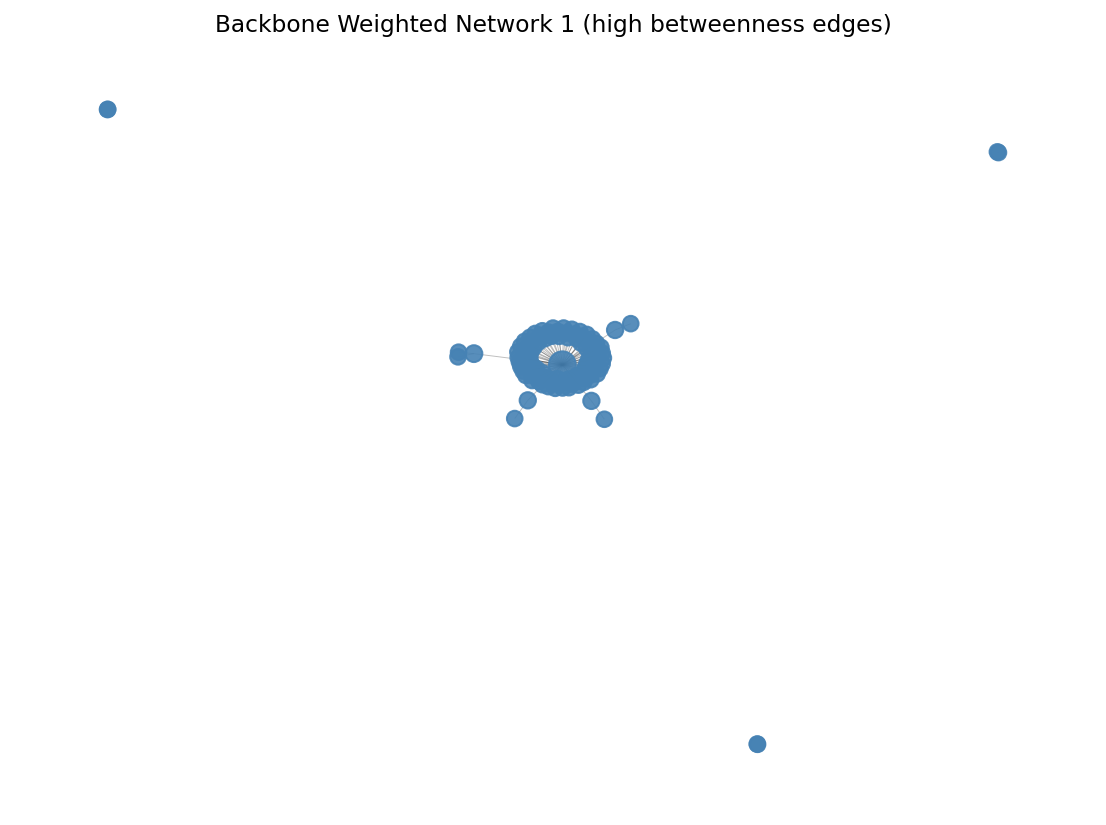

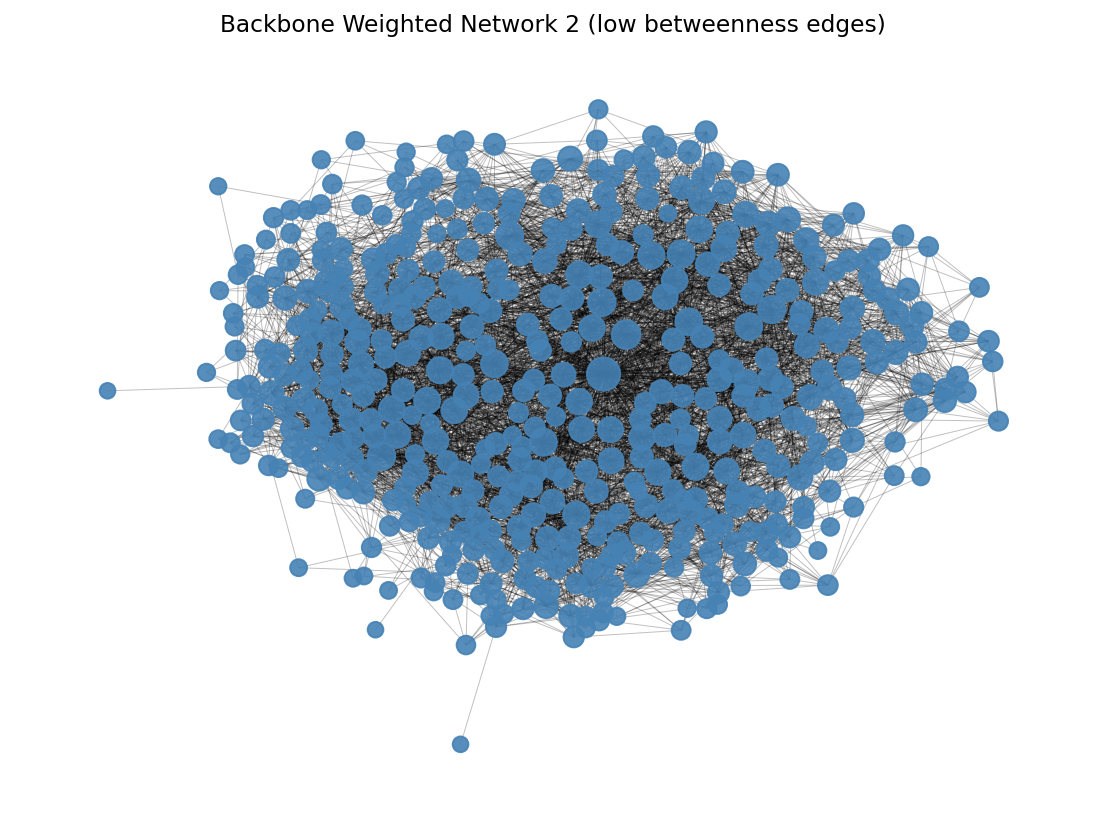

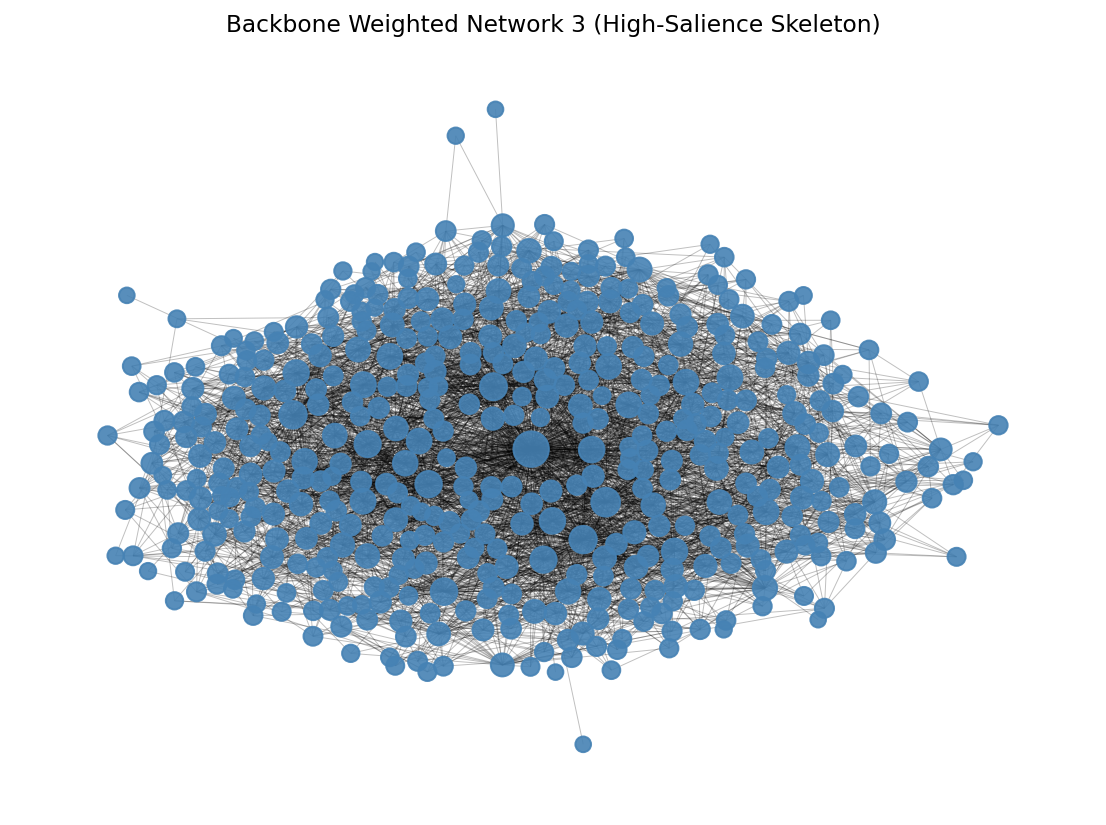

In [36]:
def plot_backbone(B, title):
    if B.number_of_edges() == 0:
        print("Backbone too sparse, adjust alpha!")
        return
    pos = nx.forceatlas2_layout(B, seed=42, max_iter=800, gravity=1.5)
    sizes = [50 + 15*np.sqrt(d) for _, d in B.degree()]
    
    plt.figure(figsize=(8,6))
    nx.draw_networkx_edges(B, pos, alpha=0.25, width=0.5)
    nx.draw_networkx_nodes(B, pos, node_size=sizes, node_color="steelblue", alpha=0.9)
    plt.title(title)
    plt.axis("off")
    plt.tight_layout()
    plt.show()

plot_backbone(B1, "Backbone Weighted Network 1 (high betweenness edges)")
plot_backbone(B2, "Backbone Weighted Network 2 (low betweenness edges)")
plot_backbone(B3, "Backbone Weighted Network 3 (High-Salience Skeleton)")


- Weighted Network 1 keeps high-betweenness edges, emphasizing bridges that connect communities. The backbone highlights global connectors.

- Weighted Network 2 keeps low-betweenness edges, emphasizing local ties within communities, at the cost of losing long-range bridges.

- Weighted Network 3 (HSS) highlights edges that occur in many shortest paths, effectively showing “highways” of information flow. This often produces a tree-like skeleton that captures essential connectivity.